In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.portfolio_management.portfolio import Portfolio, OptimizedPortfolio
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [6]:
orivault.connect()
a = orivault.retrieve("results")
orivault.disconnect()

In [7]:
valid = a[(a["position_type"]=="long") & (a["ranking_metric"]=="rolling_dollar_volume")].sort_values("pnl",ascending=False).head(20)
valid.head(20)

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,rolling_window
96,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,2024-12-20,156.518698,4.715428,33.192890,1.049240,0.863889,0.838000,1.019213,4.557422,20
288,rolling_dollar_volume,WEEK,long,OFFICE,bottom,equal,coefficient_of_variation,0.5,2024-12-20,68.062279,3.845307,17.700088,1.041775,0.920659,0.725455,1.008524,3.548999,60
160,rolling_dollar_volume,WEEK,long,OFFICE,bottom,equal,coefficient_of_variation,0.5,2024-12-20,51.006986,3.703981,13.770854,1.044222,0.921565,0.710909,1.008763,3.323127,40
416,rolling_dollar_volume,WEEK,long,OFFICE,bottom,equal,coefficient_of_variation,0.5,2024-12-20,26.178416,3.866461,6.770639,1.039761,0.922129,0.726909,1.007637,3.091839,100
352,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,2024-12-20,18.140369,1.777956,10.202932,1.013589,0.923597,0.928000,1.007110,1.263919,60
224,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,2024-12-20,16.900053,1.553083,10.881615,1.024643,0.879861,0.892000,1.009006,1.071106,40
32,rolling_dollar_volume,WEEK,long,OFFICE,bottom,equal,coefficient_of_variation,0.5,2024-12-20,13.377172,4.563823,2.931133,1.048255,0.919822,0.678364,1.006947,2.763597,20
256,rolling_dollar_volume,WEEK,long,OFFICE,mixed,equal,coefficient_of_variation,0.5,2024-12-20,4.432651,4.957021,0.894217,1.028970,0.958235,0.633636,1.003055,-0.908103,60
320,rolling_dollar_volume,WEEK,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2024-12-20,3.576675,3.728241,0.959347,1.018947,0.958509,0.734000,1.002871,-1.738700,60
128,rolling_dollar_volume,WEEK,long,OFFICE,mixed,equal,coefficient_of_variation,0.5,2024-12-20,3.500140,5.575998,0.627715,1.030292,0.957519,0.625818,1.003062,-2.779208,40


In [8]:
top = valid.head().to_dict("records")[0]
top

{'ranking_metric': 'rolling_dollar_volume',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'bottom',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-20 00:00:00'),
 'pnl': 156.51869808425616,
 'coefficient_of_variation': 4.7154284990238855,
 'portfolio_std': 33.19288970592094,
 'average_gain': 1.0492397494436312,
 'average_loss': 0.8638891357747925,
 'win_loss_ratio': 0.838,
 'weekly_return': 1.0192129500292793,
 'sharpe_ratio': 4.557422033780572,
 'rolling_window': 20}

In [9]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price,timeframe=top["rolling_window"])
            for member in RiskType:
                price = member.apply(price)	
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [03:43<00:00, 17.95it/s]


In [10]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'rolling_dollar_volume', 'adr', 'sma', 'sma_corr', 'ema', 'ema_corr',
       'ema_volume_corr', 'bollinger_upper', 'bollinger_lower', 'momentum',
       'roc', 'williams_r', 'obv', 'vwap', 'market_impact', 'atr',
       'coefficient_of_variation', 'name', 'market_cap', 'office',
       'sic_description', 'asset_class'],
      dtype='object')

In [11]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [12]:
base_portfolio = Portfolio.from_dict(top)

In [13]:
portfolios = PortfolioSelection.optimize_portfolio(base_portfolio,group_percentages=[0.001,.0065,.01])

In [14]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:35<00:00, 17.30s/it]


In [15]:
a = pd.DataFrame(analysises)
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
0,0,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.0010,16117.686174,4.560865,3533.909668,1.048772,0.900280,0.824000,1.022638,4.559381,<financial_common.portfolio_management.portfol...
2,2,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,risk,coefficient_of_variation,0.0010,1008.403313,4.625339,218.017145,1.031013,0.939821,0.824000,1.014963,4.601283,<financial_common.portfolio_management.portfol...
1,1,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,market_cap,coefficient_of_variation,0.0010,529.213360,4.320881,122.478104,1.029536,0.938568,0.823000,1.013434,4.278060,<financial_common.portfolio_management.portfol...
3,3,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.0065,6.796307,5.259428,1.292214,1.053372,0.910735,0.674943,1.007007,1.200742,<financial_common.portfolio_management.portfol...
6,6,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.0100,3.578645,4.990249,0.717128,1.053848,0.916966,0.653788,1.006458,-2.367861,<financial_common.portfolio_management.portfol...
5,5,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,risk,coefficient_of_variation,0.0065,0.292060,0.630921,0.462911,1.003954,0.993022,0.674943,1.000400,-10.698892,<financial_common.portfolio_management.portfol...
4,4,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,market_cap,coefficient_of_variation,0.0065,0.230312,0.469108,0.490958,1.003497,0.993537,0.663963,1.000150,-10.213465,<financial_common.portfolio_management.portfol...
8,8,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,risk,coefficient_of_variation,0.0100,0.178934,0.370388,0.483100,1.002962,0.995192,0.653788,1.000272,-10.552213,<financial_common.portfolio_management.portfol...
7,7,rolling_dollar_volume,WEEK,long,ASSET_CLASS,bottom,market_cap,coefficient_of_variation,0.0100,0.128840,0.255079,0.505099,1.002504,0.995726,0.641796,1.000076,-10.191797,<financial_common.portfolio_management.portfol...


In [16]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

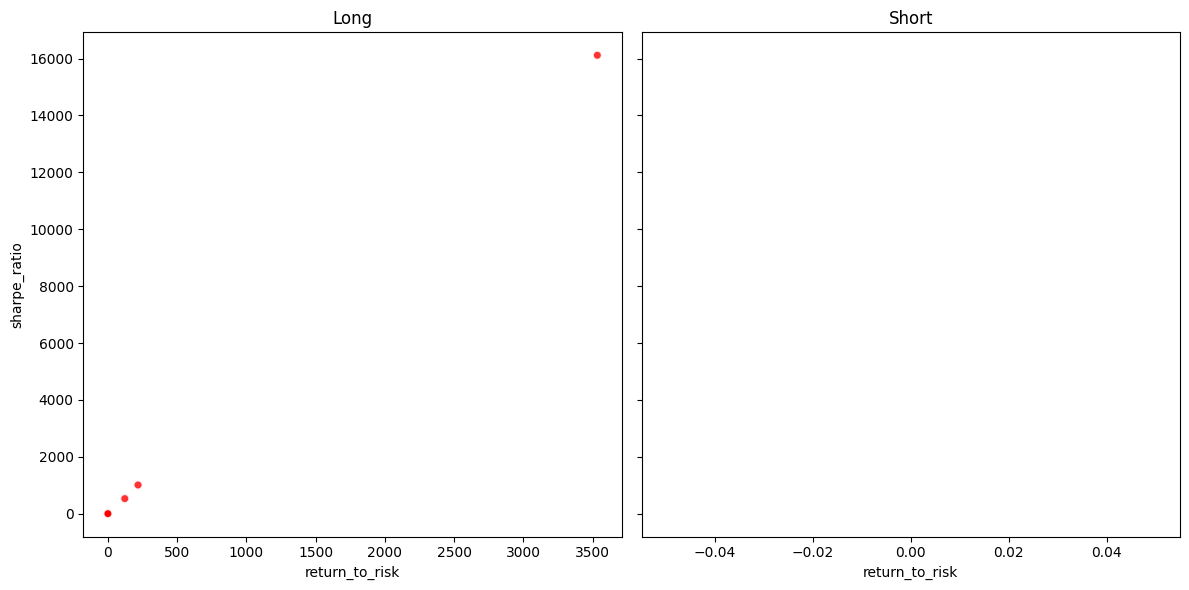

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [18]:
top = a.sort_values("pnl",ascending=False).iloc[0].to_dict()
top

{'ranking_metric': 'rolling_dollar_volume',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'bottom',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.001,
 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 'pnl': 16117.68617365843,
 'coefficient_of_variation': 4.560865354940622,
 'portfolio_std': 3533.9096683042217,
 'average_gain': 1.048772256243211,
 'average_loss': 0.9002798469444051,
 'win_loss_ratio': 0.824,
 'weekly_return': 1.022637592206621,
 'sharpe_ratio': 4.559381250459774,
 'portfolio': <financial_common.portfolio_management.portfolio.OptimizedPortfolio at 0x224c694c610>,
 'color': 'red',
 'return_to_risk': 4.560865354940622}

In [19]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [20]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [21]:
portfolio.sort_values("return",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
465,2022-04-29 00:00:00+00:00,1.470588,5604.917004,110.638001,2.454856,2022,4,2,17
102,2016-08-26 00:00:00+00:00,1.470588,17.363338,52.473041,1.164281,2016,8,3,34
99,2016-08-05 00:00:00+00:00,1.470588,10.682455,52.536434,1.165688,2016,8,3,31
114,2016-11-04 00:00:00+00:00,1.470588,35.644551,54.080324,1.199944,2016,11,4,44
293,2019-08-15 00:00:00+00:00,1.470588,358.946694,89.832255,1.993214,2019,8,3,33
246,2018-12-07 00:00:00+00:00,1.470588,170.791293,86.211282,1.912871,2018,12,4,49
531,2023-06-01 00:00:00+00:00,1.470588,5084.142578,131.808512,2.924591,2023,6,2,22
365,2020-07-15 00:00:00+00:00,1.470588,440.292851,88.176379,1.956473,2020,7,3,29
339,2020-04-08 00:00:00+00:00,1.470588,520.436607,82.573410,1.832153,2020,4,2,15
389,2020-12-04 00:00:00+00:00,1.448321,807.667086,109.149973,2.421839,2020,12,4,49


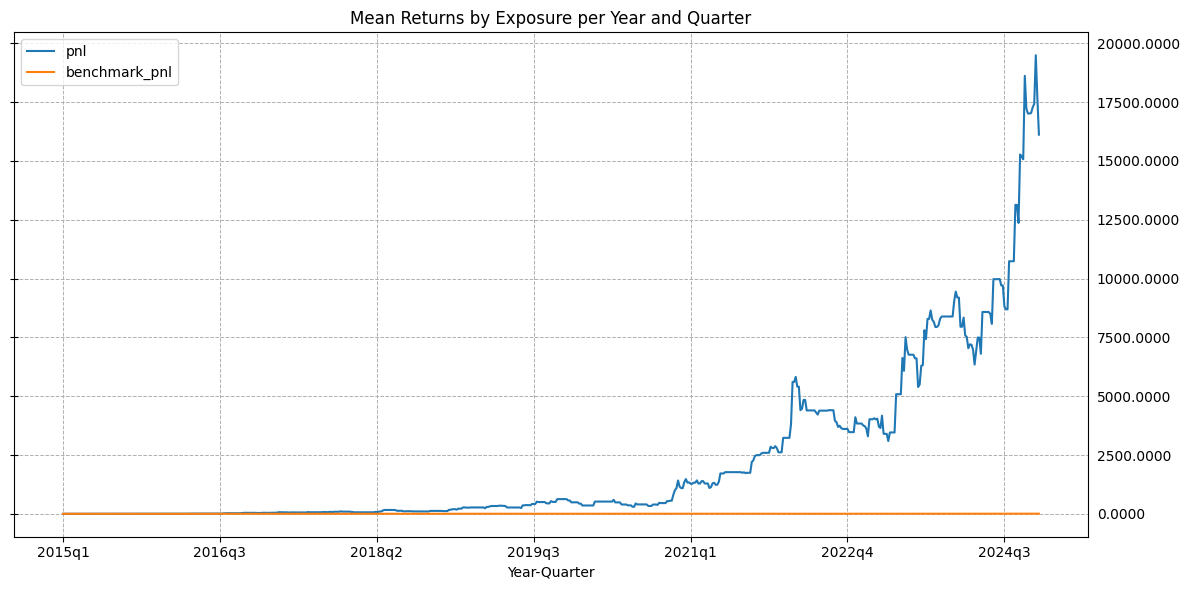

In [22]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
trades.sort_values(["date","weight"],ascending=False).dropna().head(50)

,year,week,ticker,date,adjclose,sell_price,asset_class,rolling_dollar_volume,risk,major_key,...,selection,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,quarter
2,2024,51,CAPS,2024-12-20 00:00:00+00:00,3.400000,2.760000,common_stock,2609.579500,0.165330,202451common_stock,...,True,1.0,1,0.815625,0.815625,0.815625,Capstone Holding Corp. Common Stock,1.043240e+07,12,4
27,2024,51,ASBP,2024-12-20 00:00:00+00:00,11.430000,11.500000,common_stock,1121.896520,0.031712,202451common_stock,...,True,1.0,1,1.006124,1.006124,1.006124,"Aspire Biopharma Holdings, Inc. Common Stock",2.381966e+07,12,4
9,2024,50,ASBP,2024-12-13 00:00:00+00:00,11.430000,11.430000,common_stock,1886.213680,0.032234,202450common_stock,...,True,1.0,1,1.000000,1.000000,1.000000,"Aspire Biopharma Holdings, Inc. Common Stock",2.381966e+07,12,4
121,2024,50,CAPS,2024-12-13 00:00:00+00:00,2.900000,2.290000,common_stock,434.620000,0.160491,202450common_stock,...,True,1.0,1,0.815625,0.815625,0.815625,Capstone Holding Corp. Common Stock,1.043240e+07,12,4
0,2024,49,DGICB,2024-12-06 00:00:00+00:00,14.339730,14.433051,common_stock,5101.048860,0.077360,202449common_stock,...,True,1.0,1,1.006508,1.006508,1.006508,Donegal Group Inc,6.272435e+08,12,4
8,2024,49,ODYS,2024-12-06 00:00:00+00:00,6.500000,8.000000,common_stock,2032.475250,0.049237,202449common_stock,...,True,1.0,1,1.230769,1.230769,1.230769,Odysight.ai Inc. Common Stock,8.724417e+07,12,4
1,2024,48,DGICB,2024-11-29 00:00:00+00:00,14.185909,14.344080,common_stock,4453.905579,0.079089,202448common_stock,...,True,1.0,1,1.011150,1.011150,1.011150,Donegal Group Inc,6.272435e+08,11,4
5,2024,48,ODYS,2024-11-29 00:00:00+00:00,6.112500,6.150000,common_stock,2331.971250,0.047859,202448common_stock,...,True,1.0,1,1.006135,1.006135,1.006135,Odysight.ai Inc. Common Stock,8.724417e+07,11,4
3,2024,47,ODYS,2024-11-22 00:00:00+00:00,5.990000,6.112500,common_stock,2579.505000,0.047316,202447common_stock,...,True,1.0,1,1.020451,1.020451,1.020451,Odysight.ai Inc. Common Stock,8.724417e+07,11,4
14,2024,47,ANNA,2024-11-22 00:00:00+00:00,11.070000,11.160000,common_stock,1501.997500,0.004089,202447common_stock,...,True,1.0,1,1.008130,1.008130,1.008130,"AleAnna, Inc. Class A Common Stock",3.956984e+08,11,4
